In [1]:
import torch
import pyro
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np
import os
from cities.utils.data_grabber import find_repo_root
from cities.utils.data_loader import ZoningDataset
from cities.modeling.evaluation import prep_data_for_test, test_performance

from cities.modeling.simple_linear import SimpleLinear
from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive
from chirho.robust.handlers.predictive import PredictiveModel


import matplotlib.pyplot as plt
import seaborn as sns

root = find_repo_root()

[iteration 0001] loss: 487.3362
[iteration 0050] loss: 406.3784
[iteration 0100] loss: 358.0143
[iteration 0150] loss: 338.6336
[iteration 0200] loss: 331.1601
[iteration 0250] loss: 336.0788
[iteration 0300] loss: 333.6306
[iteration 0350] loss: 330.4469
[iteration 0400] loss: 325.2328
[iteration 0450] loss: 323.6529
[iteration 0500] loss: 322.0527
[iteration 0550] loss: 322.2232
[iteration 0600] loss: 326.2723


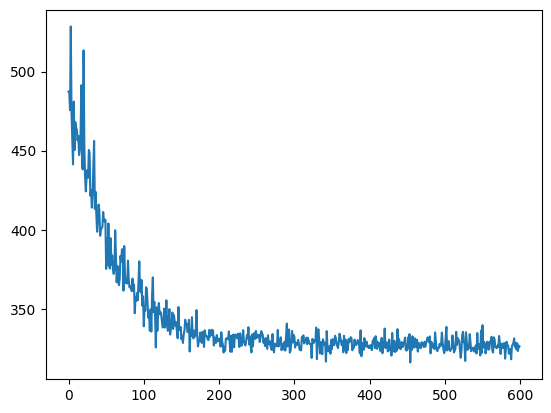

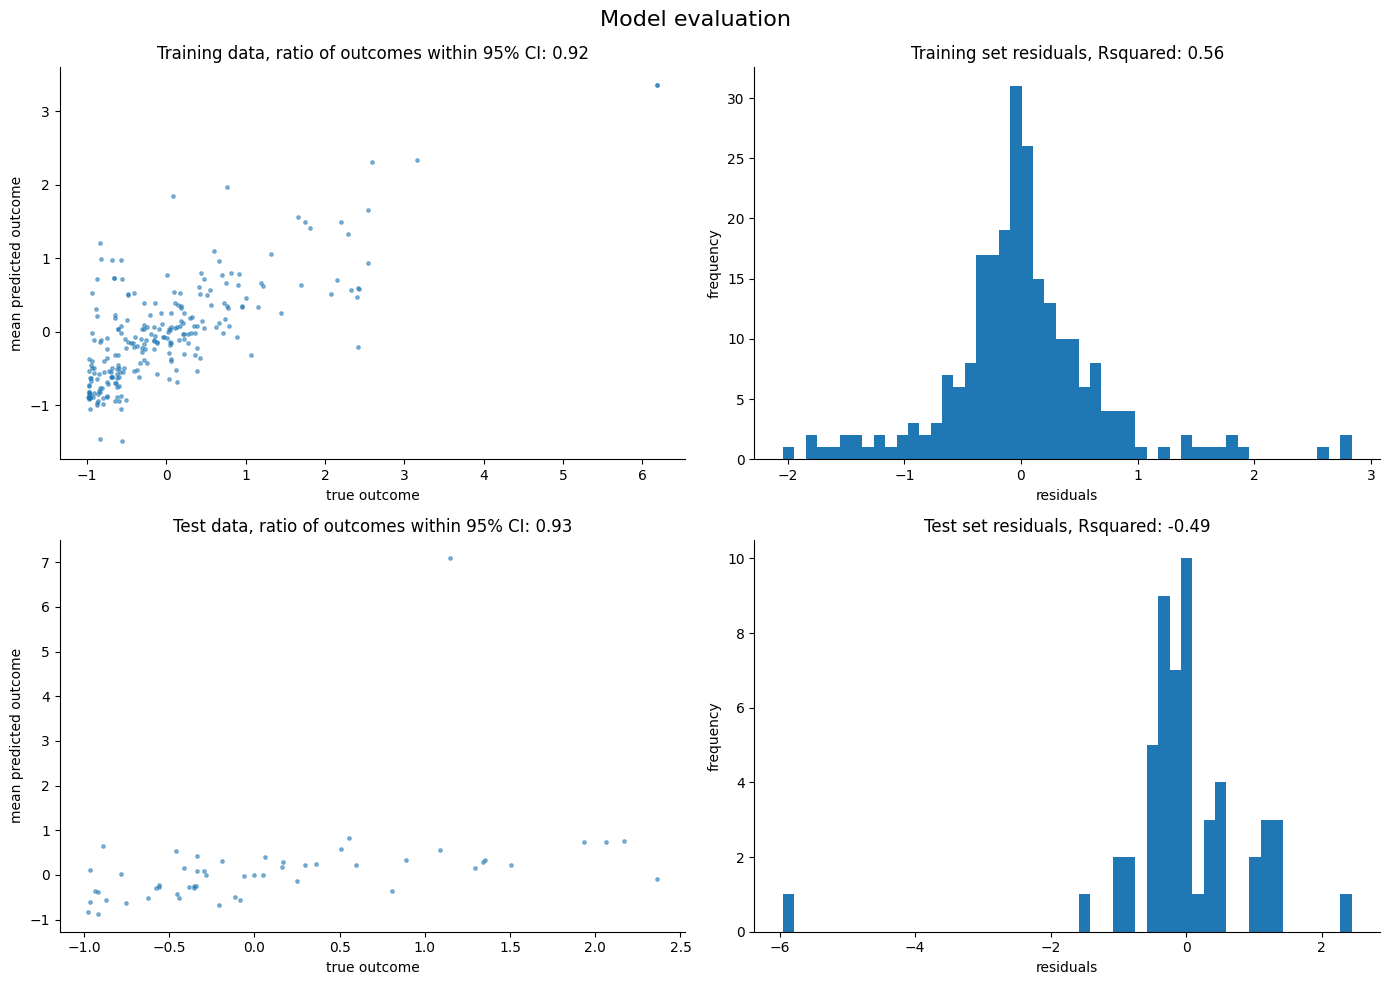

{'mae_train': 0.45349326729774475,
 'mae_test': 0.6144987940788269,
 'rsquared_train': tensor(0.5622),
 'rsquared_test': tensor(-0.4925),
 'coverage_train': 0.9211618304252625,
 'coverage_test': 0.9259259104728699}

In [2]:
train_loader, test_loader, categorical_levels = prep_data_for_test(train_size=0.8)

kwarg_names = {
    "categorical": ["limit_id", "neighborhood_id"],
    "continuous": {"parcel_area"},
    "outcome": "housing_units",
}

test_performance(
    SimpleLinear, kwarg_names, train_loader, test_loader, categorical_levels, plot=True
)

[iteration 0001] loss: 410.2183
[iteration 0050] loss: 352.8682
[iteration 0100] loss: 349.8049
[iteration 0150] loss: 349.7758
[iteration 0200] loss: 347.8140
[iteration 0250] loss: 348.8550
[iteration 0300] loss: 347.7349
[iteration 0350] loss: 348.0536
[iteration 0400] loss: 347.5929
[iteration 0450] loss: 347.8545
[iteration 0500] loss: 348.7882
[iteration 0550] loss: 347.5010
[iteration 0600] loss: 348.4998


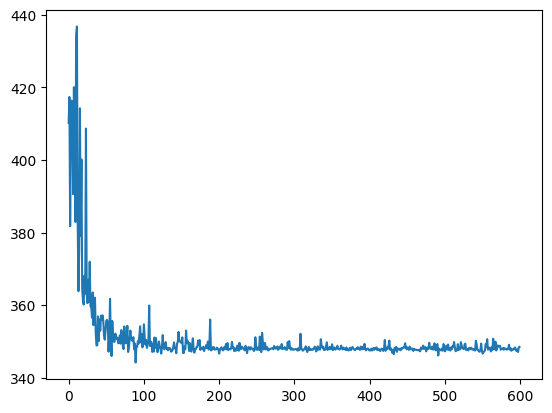

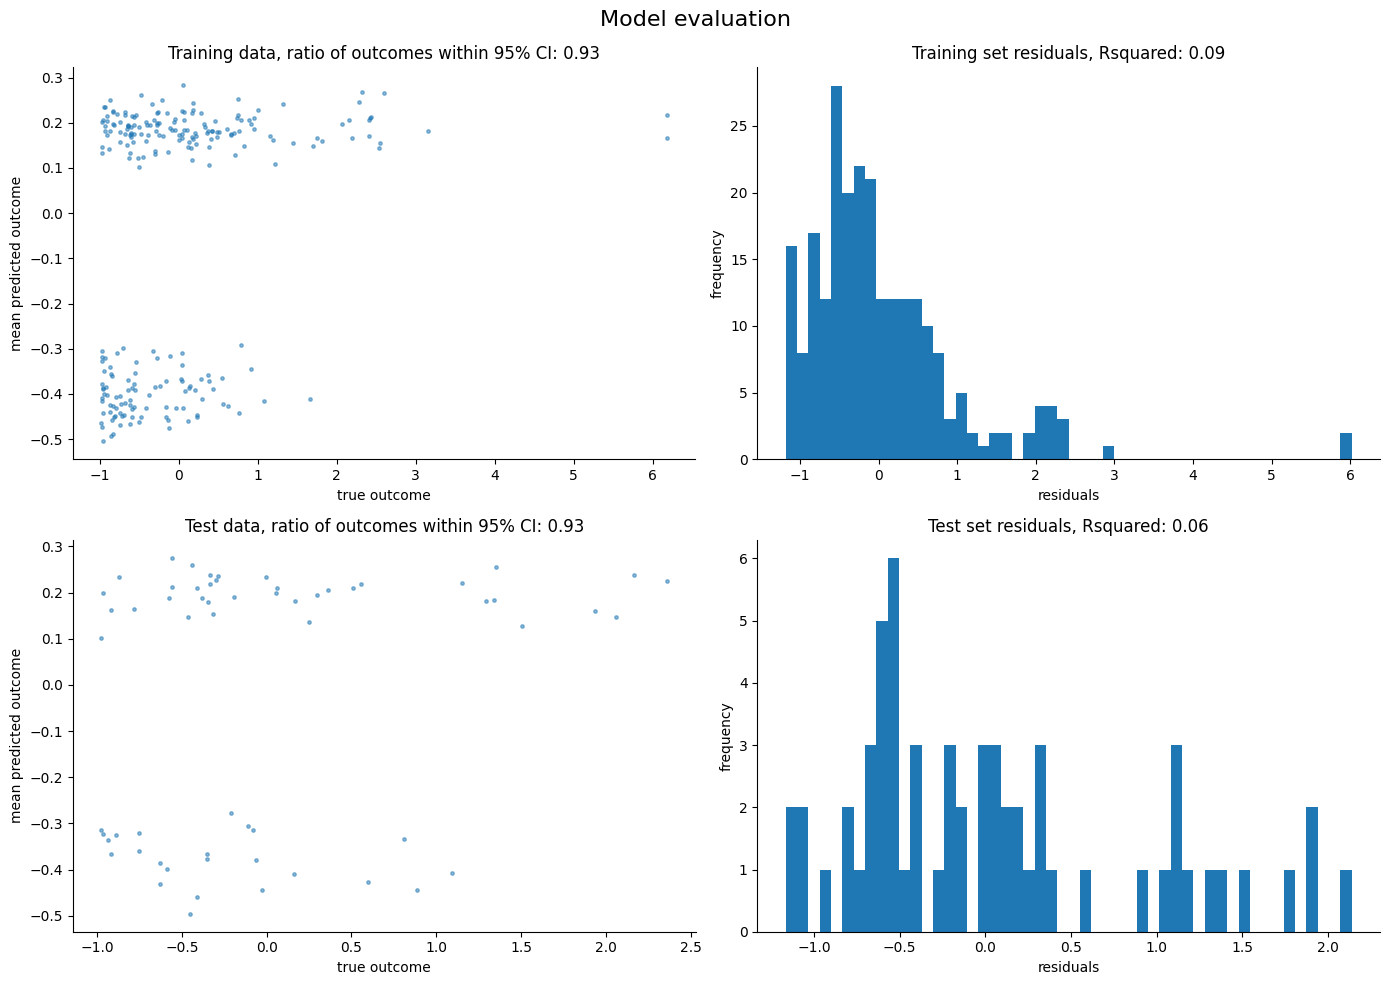

{'mae_train': 0.680559515953064,
 'mae_test': 0.6586848497390747,
 'rsquared_train': tensor(0.0868),
 'rsquared_test': tensor(0.0553),
 'coverage_train': 0.9294605851173401,
 'coverage_test': 0.9344262480735779}

In [3]:
# note just using limit id without parcel size is not very good

pyro.clear_param_store()

limit_kwarg_names = {
    "categorical": ["limit_id"],
    "continuous": {},
    "outcome": "housing_units",
}

test_performance(
    SimpleLinear,
    limit_kwarg_names,
    train_loader,
    test_loader,
    categorical_levels,
    plot=True,
)